# Chasing the Perfect Split:Modeling of the Heart Rate Response to Running at Threshold Pace

This notebook presents the data analysis performed for a math modeling project by Sebastian Kalos. 
The project aims at modeling the heart rate response to running exercise at various speeds and speed profiles.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint #https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
from lmfit import minimize, Parameters, Parameter, report_fit #download lmfit: https://lmfit.github.io/lmfit-py/installation.html
from scipy.signal import savgol_filter #https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

The following cell simply loads three datasets with time, heart rate and running speed:

In [269]:
t_integrate = 5 #time during which variables are assumed constant during a run

t_integrate = int(t_integrate)

df_sub_19_5k = pd.read_csv ('sub_19_5k.csv') #load Garmin data from a cvs files into a pandas dataframes
df_sub_20_5k = pd.read_csv ('sub_20_5k.csv')
df_sub_21_5k = pd.read_csv ('sub_21_5k.csv')


secs_sub_19 = np.array(df_sub_19_5k['secs'].tolist()) #extract time columns into arrays 
secs_sub_20 = np.array(df_sub_20_5k['secs'].tolist())
secs_sub_21 = np.array(df_sub_21_5k['secs'].tolist())

stop_idx_sub_19 = len(secs_sub_19) - len(secs_sub_19)%t_integrate #find the latest data index divisible by t_integrate
stop_idx_sub_20 = len(secs_sub_20) - len(secs_sub_20)%t_integrate
stop_idx_sub_21 = len(secs_sub_21) - len(secs_sub_21)%t_integrate

secs_sub_19 = secs_sub_19[:stop_idx_sub_19] #cut the last few datapoints so that the number of them is divisible by t_integrate
secs_sub_20 = secs_sub_20[:stop_idx_sub_20]
secs_sub_21 = secs_sub_21[:stop_idx_sub_21]

hr_sub_19 = df_sub_19_5k['hr'].tolist()[:stop_idx_sub_19] #extract heart rate data into array (cutting  the last few points too)
hr_sub_20 = df_sub_20_5k['hr'].tolist()[:stop_idx_sub_20]
hr_sub_21 = df_sub_21_5k['hr'].tolist()[:stop_idx_sub_21]

speed_kph_sub_19 = df_sub_19_5k['kph'].tolist()[:stop_idx_sub_19] #extract running speed data into array (cutting  the last few points too)
speed_kph_sub_20 = df_sub_20_5k['kph'].tolist()[:stop_idx_sub_20]
speed_kph_sub_21 = df_sub_21_5k['kph'].tolist()[:stop_idx_sub_21]

avg_speed_sub_21 = np.average(speed_kph_sub_21) #compute average speeds of each attempt
avg_speed_sub_20 = np.average(speed_kph_sub_20)
avg_speed_sub_19 = np.average(speed_kph_sub_19)

df_sub_19_5k.head() #print the header of sub-19 min attempt dataframe

,secs,cad,hr,km,kph,nm,watts,alt,lon,lat,...,interval,lrbalance,lte,rte,lps,rps,smo2,thb,o2hb,hhb
0,1,0,107,0.001118,4.02581,0,0,-3.20,54.437095,24.531051,...,0,-255,0,0,0,0,0,0,0,0
1,2,0,108,0.003040,6.91921,0,0,-1.80,54.437114,24.531051,...,0,-255,0,0,0,0,0,0,0,0
2,3,83,108,0.006894,8.31038,0,0,-1.88,54.437152,24.531057,...,0,-255,0,0,0,0,0,0,0,0
3,4,83,108,0.010749,9.70154,0,0,-1.96,54.437189,24.531062,...,0,-255,0,0,0,0,0,0,0,0
4,5,83,108,0.014603,11.09270,0,0,-2.04,54.437227,24.531068,...,0,-255,0,0,0,0,0,0,0,0


The running speed datasets are particularly noisy. A 7th order Savitzky-Golay filter (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) is used to smoothen the speed curves.

In [202]:
omit_start = t_integrate
pol_order = 7
window_size = 261
speed_profile_sub_21 = savgol_filter(speed_kph_sub_21[omit_start:], window_size, pol_order)
speed_profile_sub_20 = savgol_filter(speed_kph_sub_20[omit_start:], window_size, pol_order)
speed_profile_sub_19 = savgol_filter(speed_kph_sub_19[omit_start:], window_size, pol_order)

In the following cell, the data are simply presented on a pair of plots:

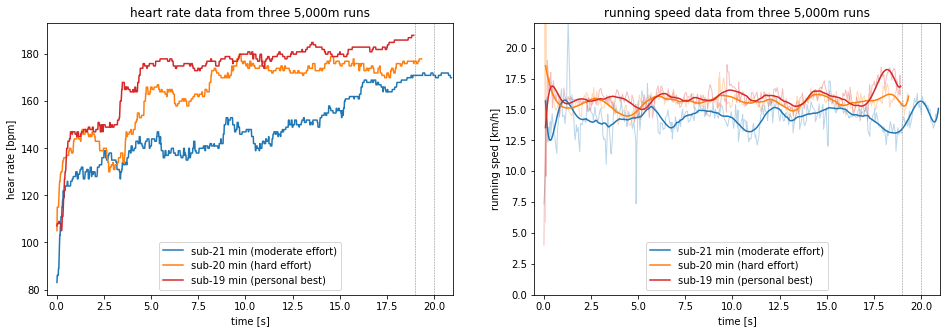

In [209]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(16, 5))

plt1.plot(secs_sub_21/60,hr_sub_21,color="tab:blue",label='sub-21 min (moderate effort)')
plt1.plot(secs_sub_20/60,hr_sub_20,color="tab:orange",label='sub-20 min (hard effort)')
plt1.plot(secs_sub_19/60,hr_sub_19,color="tab:red",label='sub-19 min (personal best)')


plt1.set_xlabel('time [s]')
plt1.set_ylabel('hear rate [bpm]')
plt1.set_title("heart rate data from three 5,000m runs")
plt1.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt1.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt1.set_xlim([-0.5,21])
plt1.legend()

plt2.plot(secs_sub_21/60,speed_kph_sub_21,color="tab:blue",alpha=0.3,linewidth=1)
plt2.plot(secs_sub_20/60,speed_kph_sub_20,color="tab:orange",alpha=0.3,linewidth=1)
plt2.plot(secs_sub_19/60,speed_kph_sub_19,color="tab:red",alpha=0.3,linewidth=1)
plt2.plot(secs_sub_21[omit_start:]/60,speed_profile_sub_21,color="tab:blue",label='sub-21 min (moderate effort)')
plt2.plot(secs_sub_20[omit_start:]/60,speed_profile_sub_20,color="tab:orange",label='sub-20 min (hard effort)')
plt2.plot(secs_sub_19[omit_start:]/60,speed_profile_sub_19,color="tab:red",label='sub-19 min (personal best)')

plt2.set_xlabel("time [s]")
plt2.set_ylabel("running sped [km/h]")
plt2.set_title("running speed data from three 5,000m runs")
plt2.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt2.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt2.set_xlim([-0.5,21])
plt2.set_ylim([0,22])
plt2.legend()

plt.savefig('heart-rate_speed_data.png', dpi=300)

The following defines the used ODE model:
$$
\begin{split}
    \dot{x}_1 &= -a_1 x_1(t) + a_2 x_2(t) + a_2 u^2(t) \\
    \dot{x}_2 &= -a_3 x_2(t)+\frac{a_4 x_1(t)}{1+e^{-(x1(t)-a_5)}}
\end{split}
$$

In [110]:
def ode_model(X,t,speed,a1,a2,a3,a4,a5):
    x1,x2 = X
    x1_dot = -a1*x1 + a2*(x2+speed**2)
    phi = a4*x1/(1+np.exp(-(x1-a5)))
    x2_dot = -a3*x2 + phi
    return [x1_dot,x2_dot]

The following cell defines two functions, both of them used for fitting the data into the five parameters. One is used for integrating the system of ODEs, while the other defines the error (deviation of real data from a fit that uses the sought parameters) which is to be minimized.

In [111]:
def integrate_speed_profile(params, t_integrate, speed_profile):

    a1, a2, a3, a4, a5 = params['a1'].value, params['a2'].value, params['a3'].value, params['a4'].value, params['a5'].value
    params = (speed_profile[0], a1, a2, a3, a4, a5)
    fit = odeint(ode_model, [0,0], np.linspace(0,t_integrate,t_integrate), args=params)

    for i in range(len(speed_profile)-1):
        next_params = (speed_profile[i+1], a1, a2, a3, a4, a5)
        next_fit = odeint(ode_model, fit[-1], np.linspace(0,t_integrate,t_integrate), args=next_params)
        fit = np.concatenate((fit, next_fit))
    return fit

def error(params,initial_conditions,t_integrate, speed_profile, data):
    sol = integrate_speed_profile(params,t_integrate, speed_profile)
    #sol = ode_solver(tspan, initial_conditions, speed_profile, params)
    return (sol[:,0] - data).ravel() #I'm only interested in minimizing x1 (there are no x2-feedback data recorded)

In [113]:
#initial conditions
x1_init = 0
x2_init = 0
initial_conditions = [x1_init, x2_init]

HR_rest_sub_19 = hr_sub_19[0] #reasting heart rate, essentially the heart rate recorded at race start
HR_rest_sub_20 = hr_sub_20[0]
HR_rest_sub_21 = hr_sub_21[0]

#initial parameter guess (estimate based on https://ieeexplore.ieee.org/document/4539791)
a1 = 2
a2 = 20
a3 = 4e-2
a4 = 2e-3
a5 = 8

params = Parameters()
params.add('a1', value=a1, min=0, max=20)
params.add('a2', value=a2, min=0, max=40)
params.add('a3', value=a3, min=0, max=5)
params.add('a4', value=a4, min=0, max=5)
params.add('a5', value=a5, min=0, max=40)

sub_21_data = (np.array(hr_sub_21)-HR_rest_sub_21)[:-t_integrate]
sub_21_result = minimize(error, params, args=(initial_conditions,t_integrate,speed_profile_sub_21[0::t_integrate], sub_21_data), method='leastsq')
sub_21_final_x1 = sub_21_data + sub_21_result.residual.reshape(sub_21_data.shape)

print("found sub-21 parameters")

sub_20_data = (np.array(hr_sub_20)-HR_rest_sub_20)[:-t_integrate]
sub_20_result = minimize(error, params, args=(initial_conditions,t_integrate,speed_profile_sub_20[0::t_integrate], sub_20_data), method='leastsq')
sub_20_final_x1 = sub_20_data + sub_20_result.residual.reshape(sub_20_data.shape)

print("found sub-20 parameters")

sub_19_data = (np.array(hr_sub_19)-HR_rest_sub_19)[:-t_integrate]
sub_19_result = minimize(error, params, args=(initial_conditions,t_integrate,speed_profile_sub_19[0::t_integrate], sub_19_data), method='leastsq')
sub_19_final_x1 = sub_19_data + sub_19_result.residual.reshape(sub_19_data.shape)

print("found sub-19 parameters")


found sub-21 parameters
found sub-20 parameters
found sub-19 parameters


In [66]:
def extract_params(result):
    a1 = result.params.valuesdict()["a1"]
    a2 = result.params.valuesdict()["a2"]
    a3 = result.params.valuesdict()["a3"]
    a4 = result.params.valuesdict()["a4"]
    a5 = result.params.valuesdict()["a5"]
    params = np.array([a1, a2, a3, a4, a5]) #return a tuple (for an easy pass into odeint())
    return params

In [67]:
sub_21_params = extract_params(sub_21_result)
sub_20_params = extract_params(sub_20_result)
sub_19_params = extract_params(sub_19_result)

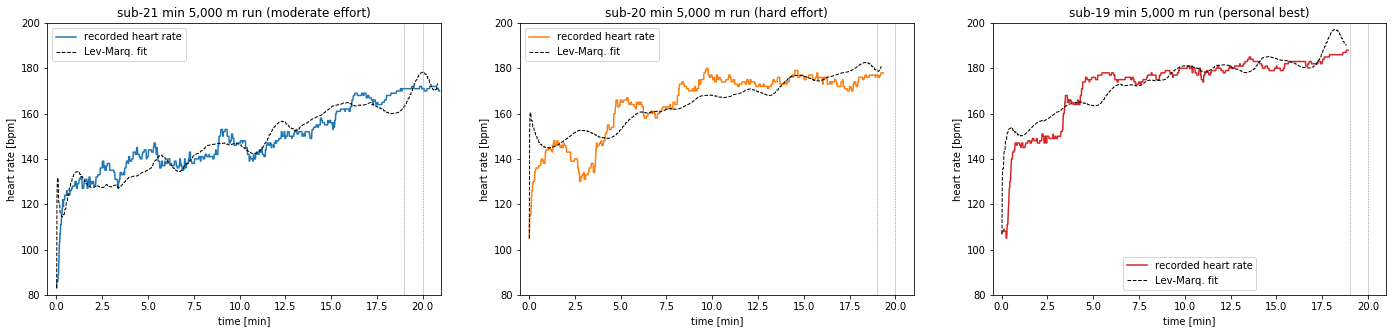

In [68]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(24, 5))

plt1.plot(secs_sub_21/60, hr_sub_21, color="tab:blue",label='recorded heart rate')
plt1.plot(secs_sub_21[:-t_integrate]/60, np.array(sub_21_final_x1)+HR_rest_sub_21, '--', linewidth=1, color='black',label="Lev-Marq. fit")
plt1.set_xlim([-0.5,21])
plt1.set_ylim([80,200])
plt1.set_xlabel("time [min]")
plt1.set_ylabel("heart rate [bpm]")
plt1.set_title("sub-21 min 5,000 m run (moderate effort)")
plt1.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt1.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt1.legend()


plt2.plot(secs_sub_20/60, hr_sub_20, color="tab:orange",label='recorded heart rate')
plt2.plot(secs_sub_20[:-t_integrate]/60, np.array(sub_20_final_x1)+HR_rest_sub_20, '--', linewidth=1, color='black',label="Lev-Marq. fit")
plt2.set_xlim([-0.5,21])
plt2.set_ylim([80,200])
plt2.set_xlabel("time [min]")
plt2.set_ylabel("heart rate [bpm]")
plt2.set_title("sub-20 min 5,000 m run (hard effort)")
plt2.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt2.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt2.legend()

plt3.plot(secs_sub_19/60, hr_sub_19, color="tab:red",label='recorded heart rate')
plt3.plot(secs_sub_19[:-t_integrate]/60, np.array(sub_19_final_x1)+HR_rest_sub_19, '--', linewidth=1, color='black',label="Lev-Marq. fit")
plt3.set_xlim([-0.5,21])
plt3.set_ylim([80,200])
plt3.set_xlabel("time [min]")
plt3.set_ylabel("heart rate [bpm]")
plt3.set_title("sub-19 min 5,000 m run (personal best)")
plt3.axvline(x=20,color="grey",linestyle='--',linewidth=0.5)
plt3.axvline(x=19,color="grey",linestyle='--',linewidth=0.5)
plt3.legend(loc="lower center")

plt.savefig('heart_rate_fits.png', dpi=300)

In [116]:
def params_to_tuple(pars):
    a1 = pars[0]
    a2 = pars[1]
    a3 = pars[2]
    a4 = pars[3]
    a5 = pars[4]
    params = Parameters()
    params.add('a1', value=a1, min=0, max=20)
    params.add('a2', value=a2, min=0, max=40)
    params.add('a3', value=a3, min=0, max=5)
    params.add('a4', value=a4, min=0, max=5)
    params.add('a5', value=a5, min=0, max=40)
    return(params)

def result_to_tuple(result):
    a1 = result.params.valuesdict()["a1"]
    a2 = result.params.valuesdict()["a2"]
    a3 = result.params.valuesdict()["a3"]
    a4 = result.params.valuesdict()["a4"]
    a5 = result.params.valuesdict()["a5"]
    params = Parameters()
    params.add('a1', value=a1, min=0, max=20)
    params.add('a2', value=a2, min=0, max=40)
    params.add('a3', value=a3, min=0, max=5)
    params.add('a4', value=a4, min=0, max=5)
    params.add('a5', value=a5, min=0, max=40)
    return(params)

Text(0, 0.5, 'heart rate [bpm]')

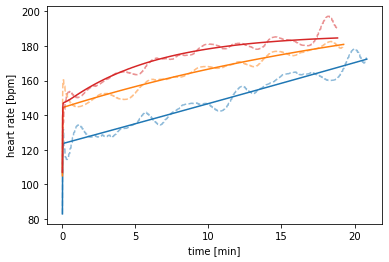

In [118]:
sub_21_fit = integrate_speed_profile(result_to_tuple(sub_21_result), t_integrate, speed_profile_sub_21[0::t_integrate])
const_speed_profile_sub_21 = np.full((len(speed_profile_sub_21[0::t_integrate])),avg_speed_sub_21)
sub_21_const_fit = integrate_speed_profile(result_to_tuple(sub_21_result), t_integrate, const_speed_profile_sub_21)

plt.plot(secs_sub_21[:-t_integrate]/60,sub_21_fit[:,0]+HR_rest_sub_21,color="tab:blue",alpha=0.5,linestyle="--",label="sub-21 min (variable speed)")
plt.plot(secs_sub_21[:-t_integrate]/60,sub_21_const_fit[:,0]+HR_rest_sub_21,color="tab:blue",label="sub-21 min (constant speed)")



sub_20_fit = integrate_speed_profile(result_to_tuple(sub_20_result), t_integrate, speed_profile_sub_20[0::t_integrate])
const_speed_profile_sub_20 = np.full((len(speed_profile_sub_20[0::t_integrate])),avg_speed_sub_20)
sub_20_const_fit = integrate_speed_profile(result_to_tuple(sub_20_result), t_integrate, const_speed_profile_sub_20)

plt.plot(secs_sub_20[:-t_integrate]/60,sub_20_fit[:,0]+HR_rest_sub_20,color="tab:orange",alpha=0.5,linestyle="--",label="sub-20 min (variable speed)")
plt.plot(secs_sub_20[:-t_integrate]/60,sub_20_const_fit[:,0]+HR_rest_sub_20,color="tab:orange",label="sub-20 min (constant speed)")


sub_19_fit = integrate_speed_profile(result_to_tuple(sub_19_result), t_integrate, speed_profile_sub_19[0::t_integrate])
const_speed_profile_sub_19 = np.full((len(speed_profile_sub_19[0::t_integrate])),avg_speed_sub_19)
sub_19_const_fit = integrate_speed_profile(result_to_tuple(sub_19_result), t_integrate, const_speed_profile_sub_19)

plt.plot(secs_sub_19[:-t_integrate]/60,sub_19_fit[:,0]+HR_rest_sub_19,color="tab:red",alpha=0.5,linestyle="--",label="sub-19 min (variable speed)")
plt.plot(secs_sub_19[:-t_integrate]/60,sub_19_const_fit[:,0]+HR_rest_sub_19,color="tab:red",label="sub-19 min (constant speed)")

#plt.legend()
plt.xlabel("time [min]")
plt.ylabel("heart rate [bpm]")


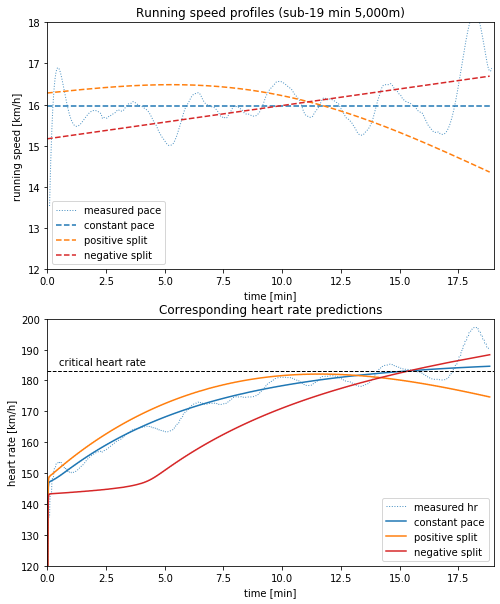

In [268]:
N = len(const_speed_profile_sub_19)
t = secs_sub_19[:-t_integrate]
tau = np.linspace(0,N*t_integrate,N)
avg_speed = avg_speed_sub_19


fit_1 = integrate_speed_profile(params_to_tuple(sub_19_params), t_integrate, const_speed_profile_sub_19)

profile_2 = np.array(const_speed_profile_sub_19) + np.sin(np.pi*tau/tau[-1]) - np.linspace(-1,1,len(const_speed_profile_sub_19))
#normalize speed profile:
dist = 0
for speed in profile_2:
    dist += speed/3.6*t_integrate
profile_2 = profile_2*5000/dist
fit_2 = integrate_speed_profile(params_to_tuple(sub_19_params), t_integrate, profile_2)

profile_3 = np.array(const_speed_profile_sub_19) + np.linspace(-1,0.5,len(const_speed_profile_sub_19))
#normalize speed profile:
dist = 0
for speed in profile_3:
    dist += speed/3.6*t_integrate
profile_3 = profile_3*5000/dist
fit_3 = integrate_speed_profile(params_to_tuple(sub_19_params), t_integrate, profile_3)

fig, (plt1, plt2) = plt.subplots(2, 1, figsize=(8, 10))

plt1.plot(secs_sub_19[omit_start:]/60,speed_profile_sub_19,color="tab:blue",alpha=0.8,linewidth=1,linestyle=":",label='measured pace')
plt1.plot(tau/60,const_speed_profile_sub_19,color="tab:blue",linestyle="--",label="constant pace")
plt1.plot(tau/60,profile_2,color="tab:orange",linestyle="--",label="positive split")
plt1.plot(tau/60,profile_3,color="tab:red",linestyle="--",label="negative split")
plt1.set_ylim([12,18])
plt1.set_xlabel("time [min]")
plt1.set_ylabel("running speed [km/h]")
plt1.set_title("Running speed profiles (sub-19 min 5,000m)")
plt1.legend(loc="lower left")
plt1.set_xlim([0,19])

plt2.plot(secs_sub_19[:-t_integrate]/60,sub_19_fit[:,0]+HR_rest_sub_19,color="tab:blue",linewidth=1,alpha=0.8,linestyle=":",label="measured hr")
plt2.plot(t/60,fit_1[:,0]+HR_rest_sub_19,color="tab:blue",label="constant pace")
plt2.plot(t/60,fit_2[:,0]+HR_rest_sub_19,color="tab:orange",label="positive split")
plt2.plot(t/60,fit_3[:,0]+HR_rest_sub_19,color="tab:red",label="negative split")
plt2.axhline(y=183,color="black",linestyle="--",linewidth=1)
plt2.set_xlabel("time [min]")
plt2.set_ylabel("heart rate [km/h]")
plt2.set_title("Corresponding heart rate predictions")
plt2.legend(loc="lower right")
plt2.text(x=0.5,y=185,s="critical heart rate")
plt2.set_xlim([0,19])
plt2.set_ylim([120,200])

plt.savefig('hr_predictions.png', dpi=300)